In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
import re

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import PolynomialFeatures

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [25]:
from sklearn.ensemble import StackingClassifier

In [7]:
df=pd.read_csv("train.csv")

<h2>Create a use time feature now</h2>

In [8]:
df['LastRecord']= pd.to_datetime(df['LastRecord'])
df['Date Deployed']= pd.to_datetime(df['Date Deployed'])


In [9]:
df['use_time']=df['LastRecord']-df['Date Deployed']
df['use_time']=df['use_time'].astype('timedelta64[D]').astype(int)

In [10]:
use_time=pd.DataFrame(df['use_time'])
use_time.head(5)

,use_time
0,543
1,522
2,518
3,548
4,566


<h2>Preprocessing</h2>

In [11]:
X_train=df.drop(['deviceid','LastRecord','Date Deployed','fail_7'],axis=1)
Y_train=df['fail_7']


In [12]:
Y_train.isnull().sum()

0

In [13]:
Y_train.sum()/len(Y_train)

0.23212345679012344

<h4>Scale & Treat Missing Values</h4>

In [14]:
pipeline=Pipeline([('preprocessing',StandardScaler()),('imputer',KNNImputer())])
X_train_transformed=pipeline.fit_transform(X_train)
X_train_transformed=pd.DataFrame(X_train_transformed,columns=X_train.columns)

<h4>Remove Outliers</h4>

In [15]:
iso=IsolationForest(random_state=0)
iso.fit(X_train_transformed)

IsolationForest(random_state=0)

In [16]:
pred=iso.predict(X_train_transformed)


In [17]:
non_outlier_index=(pred!=-1)

In [18]:
X_train_transformed=X_train_transformed[non_outlier_index]
Y_train_transformed=Y_train[non_outlier_index]

In [19]:
X_train_transformed.shape

(38112, 52)

In [20]:
df_transformed=pd.concat([X_train_transformed,pd.DataFrame(Y_train_transformed)],axis=1).reset_index(drop=True)


In [21]:
df_transformed.head(5)

,avg_time_charging_lag1,avg_time_charging_lag2,avg_time_charging_lag3,avg_time_charging_lag7,charging_rate_lag3,charging_rate_lag7,avg_time_discharging_lag1,avg_time_discharging_lag2,avg_time_discharging_lag3,avg_time_discharging_lag7,...,number_times_restart,avg_volt_change_charging,avg_volt_change_discharging,avg_time_charging,avg_time_discharging,max_voltage_day,piececount,cycle_time,use_time,fail_7
0,1.322035,-0.736535,-0.656490,-0.620662,0.231943,-1.643846,1.260757,-0.672922,-0.674548,-0.614943,...,-0.519458,-0.070922,0.158275,0.993651,0.899960,0.153353,-0.045461,0.936226,-1.263578,0
1,-0.700191,-0.744314,-0.768220,-0.686725,-0.536665,-0.040072,-0.706853,-0.702794,-0.743562,-0.415954,...,0.872781,-0.416504,-0.361379,-0.753399,-0.823473,-0.621582,-0.080560,-0.803012,-1.444093,0
2,-0.755478,1.512328,1.272963,1.607623,0.154653,0.061266,-0.747888,1.697835,1.194297,1.636361,...,-0.637826,0.373663,0.123287,-0.012855,0.015783,0.474543,0.188245,0.005993,-0.090230,0
3,-0.726859,1.732092,-0.761032,-0.732968,0.107420,-0.132597,-0.721899,1.530484,-0.755178,-0.682537,...,-0.459485,1.528587,1.470311,0.687980,0.694247,0.931658,-0.477438,0.695180,0.722088,0
4,0.745743,-0.739128,1.706159,-0.719756,0.154653,0.043642,0.687298,-0.759144,1.699260,-0.749097,...,-0.002188,-0.084446,-0.109980,-0.977604,-0.948294,-0.678018,-0.859637,-0.962608,-0.270745,0


<h2>Feature Engineering</h2>

<h4>Feature Importance</h4>

In [122]:
gbdt = GradientBoostingClassifier(random_state=0)
gbdt.fit(X_train_transformed, Y_train_transformed)


GradientBoostingClassifier(random_state=0)

In [127]:
#function to plot feature imprtance
def plot_feature_importances(model):
    n_features = X_train_transformed.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_train_transformed.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

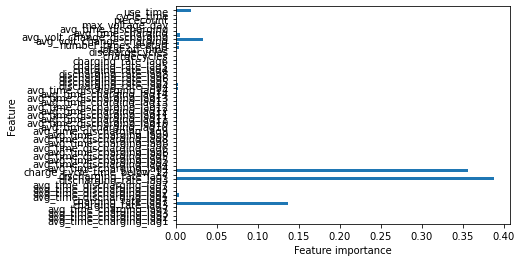

In [128]:
plot_feature_importances(gbdt)

<div class="alert-success">
Top 5 features dominates 

In [131]:

pd.set_option('display.max_rows', None)
df_featureImportance=pd.DataFrame(gbdt.feature_importances_,index=X_train_transformed.columns,columns=['Importance Value'])

df_featureImportance.sort_values(by=['Importance Value'],ascending=False).head(10)



,Importance Value
discharging_rate_lag3,0.388741
charge_cycle_time_below_12,0.356818
charging_rate_lag3,0.136586
avg_volt_change_charging,0.033035
use_time,0.019237
avg_volt_change_discharging,0.005545
total_off_time,0.004736
avg_time_discharging_lag1,0.003715
number_times_restart,0.003694
avg_time_discharging_lag14,0.002698


<h4>Model Pre-selection</h4>

<div class="alert-success">
Use default model parameters to select a model for testing feature selections

In [138]:
models = []


# Gaussian Naive Bayes
models.append(('NB', GaussianNB())) 


# Logistic regression
models.append(('LR', LogisticRegression()))

#KNN
models.append(('KNN',KNeighborsClassifier()))

#Kernalize SVM
models.append(('SVM',SVC()))

#GBDT
models.append(('GBDT', GradientBoostingClassifier(random_state=0)))

#RF
models.append(('RF', RandomForestClassifier(random_state=0)))

#Neural Network
models.append(('MLP',MLPClassifier(random_state=0)))

In [140]:

#For int/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used
names = []
results = []
for name,model in models:
    kfold = StratifiedKFold(n_splits=5, random_state=0,shuffle=True)
    cv_results = cross_val_score(model, 
                                 X_train_transformed,
                                 Y_train_transformed, cv=kfold, scoring='accuracy',n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name,cv_results.mean(),cv_results.std()))

NB: 0.627466 (0.011617)
LR: 0.765586 (0.001852)
KNN: 0.726622 (0.005926)
SVM: 0.765822 (0.000015)
GBDT: 0.811818 (0.002791)
RF: 0.795891 (0.002208)
MLP: 0.726123 (0.007150)


<div class="alert-success">
GBDT has the best performance, use this as model of evaluation for feature selections

<div class="alert-danger">
There is data leakage in cross-validation, we will solve that using pipeline in final model building and evaluation

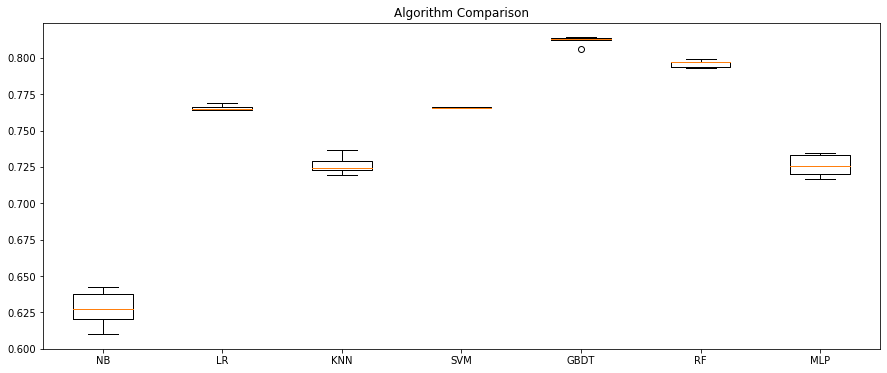

In [141]:
# Compare Algorithms
fig,ax = plt.subplots(figsize=(15,6))
ax.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show() 
#USE GBDT AS EVALUATION METHOD FOR NOW

<h4>Trend</h4>

In [155]:
#calculate average of one day for entire rows in a column, to show trend in the lags
def plot_by_group(pattern):
    match=[]
    names=[]
    for item in df.columns:
        result = re.match(pattern, item)
        match.append(bool(result))
        if bool(result):
            names.append(item)
    group=df[names]
    group.mean().plot(kind="line")
    plt.show()

<div class="alert-success">

-charging/discharging_rate_lag3(AKA. recent Monday) has significant lowest rate

-charging/discharging_avg_time_lag3 has significant highest time

"Monday Effect": on recent Monday, has lowest charging rate and highest charging time ->busy 

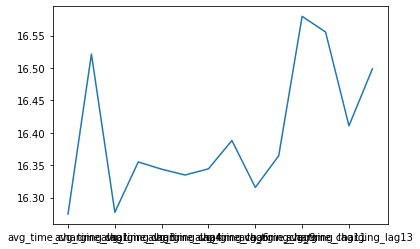

In [156]:
plot_by_group("^avg_time_charging_lag")

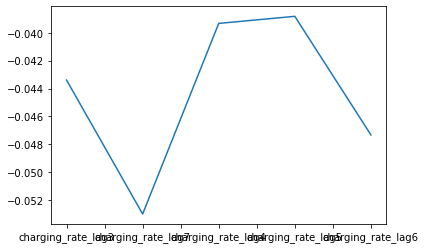

In [157]:
plot_by_group("^charging_rate_lag")

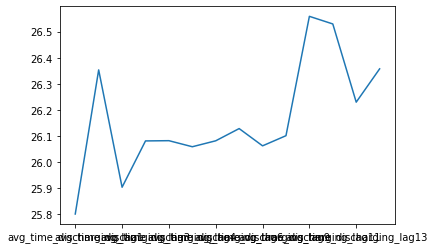

In [158]:
plot_by_group("^avg_time_discharging_lag")

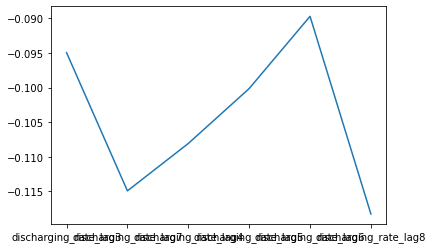

In [159]:
plot_by_group("^discharging_rate_lag")

<h4>Correlation Heatmap</h4>

In [161]:
df_plot = df[[ 'avg_time_charging', 
                  'avg_time_discharging' , 'avg_volt_change_charging',
                  'avg_volt_change_discharging', 'charge_cycle_time_below_12', 'chargecycles', 'cycle_time', 
                  'dischargecycles', 'fail_7', 'max_voltage_day', 'number_times_restart', 'piececount', 
                  'total_off_time','use_time']]

Text(0.5, 1.0, 'Correlation Matrix Pearson Method')

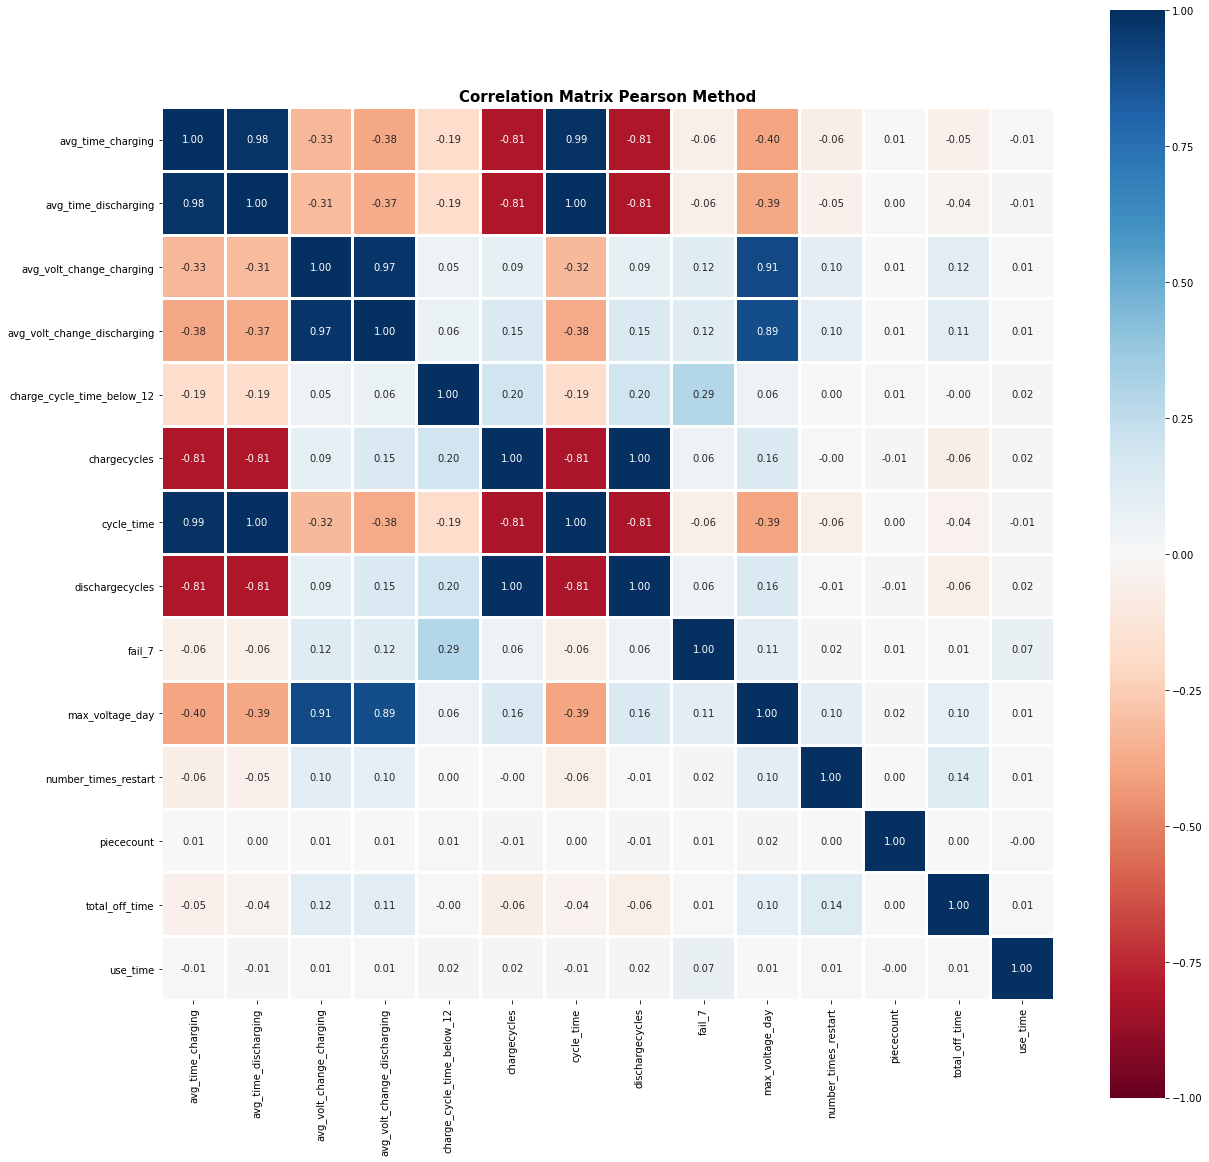

In [162]:
# Pearson Correlation Heatmap
plt.figure(figsize = (20, 20))
sns.heatmap(df_plot.corr(method = 'pearson'), annot = True, fmt = ".2f", cmap = 'RdBu', vmin = -1, vmax = 1, center = 0,
            square = True, linewidths = 2)
plt.title("Correlation Matrix Pearson Method", size = 15, weight = 'bold')

<h4>Feature Selection</h4>

In [47]:


core_features=['discharging_rate_lag3','charge_cycle_time_below_12','charging_rate_lag3','avg_volt_change_charging',
               'use_time']

X_train_core=df_transformed[core_features]
Y_train_core=df_transformed['fail_7']

gbdt=GradientBoostingClassifier(random_state=0)


score_record=cross_val_score(gbdt,X_train_core,Y_train_core,cv=StratifiedKFold(n_splits=5, random_state=0,shuffle=True),
                             scoring='accuracy',n_jobs=-1).mean()

<div class="alert-danger">

Core features only outperforms whole feature!

0.813 of top 5 features>0.812 of all features


In [48]:
score_record

0.813103390067203

<h4>Feature Engineering & Combination</h4>

<h5>Combine top 5 features</h5>

In [49]:

core_features=['discharging_rate_lag3','charge_cycle_time_below_12','charging_rate_lag3','avg_volt_change_charging',
               'use_time']



In [50]:
poly=PolynomialFeatures(2)
X_train_poly=poly.fit_transform(X_train_transformed[core_features])


In [51]:
gbdt=GradientBoostingClassifier(random_state=0)



score_record=cross_val_score(gbdt,X_train_poly,Y_train_transformed,
                             cv=StratifiedKFold(n_splits=5, random_state=0,shuffle=True),
                             scoring='accuracy',n_jobs=-1).mean()

<div class="alert-info">
improve only a little bit by including interaction terms and polynomial terms

In [52]:
score_record

0.8131821405431291

<h5>Average of time series variable</h5>

In [57]:
match=[]
names=[]
pattern="^charging_rate_lag"
for item in df_transformed.columns:
    result = re.match(pattern, item)
    match.append(bool(result))
    if bool(result):
        names.append(item)

In [62]:
names

['charging_rate_lag3',
 'charging_rate_lag7',
 'charging_rate_lag4',
 'charging_rate_lag5',
 'charging_rate_lag6']

In [66]:
X_train_eng=X_train_transformed
#col mean
X_train_eng['avg_charging_rate']=X_train_transformed[names].mean(axis=1)

In [68]:
match=[]
names=[]
pattern="^discharging_rate_lag"
for item in df_transformed.columns:
    result = re.match(pattern, item)
    match.append(bool(result))
    if bool(result):
        names.append(item)

In [69]:
names

['discharging_rate_lag3',
 'discharging_rate_lag7',
 'discharging_rate_lag4',
 'discharging_rate_lag5',
 'discharging_rate_lag6',
 'discharging_rate_lag8']

In [70]:

#col mean
X_train_eng['avg_discharging_rate']=X_train_eng[names].mean(axis=1)

In [71]:
X_train_eng.head()

,avg_time_charging_lag1,avg_time_charging_lag2,avg_time_charging_lag3,avg_time_charging_lag7,charging_rate_lag3,charging_rate_lag7,avg_time_discharging_lag1,avg_time_discharging_lag2,avg_time_discharging_lag3,avg_time_discharging_lag7,...,avg_volt_change_charging,avg_volt_change_discharging,avg_time_charging,avg_time_discharging,max_voltage_day,piececount,cycle_time,use_time,avg_charging_rate,avg_discharging_rate
1,1.322035,-0.736535,-0.656490,-0.620662,0.231943,-1.643846,1.260757,-0.672922,-0.674548,-0.614943,...,-0.070922,0.158275,0.993651,0.899960,0.153353,-0.045461,0.936226,-1.263578,-0.436811,-1.161387
2,-0.700191,-0.744314,-0.768220,-0.686725,-0.536665,-0.040072,-0.706853,-0.702794,-0.743562,-0.415954,...,-0.416504,-0.361379,-0.753399,-0.823473,-0.621582,-0.080560,-0.803012,-1.444093,-0.093674,-0.133339
3,-0.755478,1.512328,1.272963,1.607623,0.154653,0.061266,-0.747888,1.697835,1.194297,1.636361,...,0.373663,0.123287,-0.012855,0.015783,0.474543,0.188245,0.005993,-0.090230,0.511536,0.068334
4,-0.726859,1.732092,-0.761032,-0.732968,0.107420,-0.132597,-0.721899,1.530484,-0.755178,-0.682537,...,1.528587,1.470311,0.687980,0.694247,0.931658,-0.477438,0.695180,0.722088,0.443132,-0.184018
5,0.745743,-0.739128,1.706159,-0.719756,0.154653,0.043642,0.687298,-0.759144,1.699260,-0.749097,...,-0.084446,-0.109980,-0.977604,-0.948294,-0.678018,-0.859637,-0.962608,-0.270745,0.271213,0.188178


In [73]:
features=['discharging_rate_lag3','charge_cycle_time_below_12','charging_rate_lag3','avg_volt_change_charging',
               'use_time','avg_charging_rate','avg_discharging_rate']


gbdt=GradientBoostingClassifier(random_state=0)



score_record=cross_val_score(gbdt,X_train_eng[features],Y_train_transformed,
                             cv=StratifiedKFold(n_splits=5, random_state=0,shuffle=True),
                             scoring='accuracy',n_jobs=-1).mean()

<div class="alert-info">
Performance decreased

In [74]:
score_record

0.8125524086689134

<div class="alert-info">
Stick to orginal features

<h2>Model Evaluation</h2>

<div class="alert-danger">
It is hard to chain outlier removal to pipeline & outliers in this case has meanings, so we keep outliers

<h4>GBDT pipeline</h4>

In [53]:
pipeline=Pipeline([('preprocessing',StandardScaler()),('imputer',KNNImputer()),
                   ('classifier',GradientBoostingClassifier())])

In [54]:
param_grid=[
    {
        'preprocessing':[StandardScaler()],
        'imputer': [KNNImputer()],
        'classifier':[GradientBoostingClassifier(random_state=0)]
    }
]

<div class="alert-info">
Use pipeline to avoid data leakage, getting about same score as before

In [55]:
grid=GridSearchCV(pipeline,param_grid,cv=5,n_jobs=-1)
grid.fit(X_train,Y_train)
print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best params:
{'classifier': GradientBoostingClassifier(random_state=0), 'imputer': KNNImputer(), 'preprocessing': StandardScaler()}

Best cross-validation score: 0.81


<div class="alert-info">
Very time comsuimng to do cross validation and tuning, 
so we do training set validation now for Logistic Regression and Neural Network

<h4>Logistic Regression Training Set Tuning</h4>

Choose ElasticNet since it incroporates L1,L2 regularization, 
and we are not leaving one of the correlated features out as Lasso does

In [22]:
best_score = 0

for C in [1,10,50]:
    for l1_ratio in [0.2,0.5,0.8]:
        pipeline=Pipeline(
            [
               ('classifier',LogisticRegression(C=C,l1_ratio=l1_ratio,
                                                penalty='elasticnet',solver='saga',multi_class='ovr',
                                                max_iter=1000,n_jobs=-1))
            ]
                        )
        pipeline.fit(X_train_transformed,Y_train_transformed)
        score = pipeline.score(X_train_transformed, Y_train_transformed)
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'l1_ratio': l1_ratio}
            
print("Best score: {:.2f}".format(best_score))
print("Best parameters: {}".format(best_parameters))


Best score: 0.77
Best parameters: {'C': 1, 'l1_ratio': 0.5}


<h4>Neural Network</h4>

In [23]:
best_score = 0

for hidden_layer_sizes in [[1],[5],[1,1],[5,5]]:
    pipeline=Pipeline(
        [
           ('classifier', MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,random_state=0))
        ]
                    )
    pipeline.fit(X_train_transformed,Y_train_transformed)
    score = pipeline.score(X_train_transformed, Y_train_transformed)
    if score > best_score:
        best_score = score
        best_parameters = {'hidden_layer_sizes': hidden_layer_sizes}
            
print("Best score: {:.2f}".format(best_score))
print("Best parameters: {}".format(best_parameters))

Best score: 0.77
Best parameters: {'hidden_layer_sizes': [5]}


-SVM takes too long to run and does not scale well in large samples datasets

-Random Forest generally underperforms by GBDT

-Logistic regression and Neural Network as shown above does not perform well enough 



<h3>Ensembling</h3>

Use Stacking

In [26]:
estimator_stacking=[]
estimator_stacking.append(('GBDT',GradientBoostingClassifier(random_state=0)))
estimator_stacking.append(('MLP',MLPClassifier(random_state=0,hidden_layer_sizes=[5])))
estimator_stacking.append(('LR',LogisticRegression(C=1,l1_ratio=0.5,
                                                penalty='elasticnet',solver='saga',multi_class='ovr',
                                                max_iter=1000,n_jobs=-1)))

In [27]:
stacking = StackingClassifier(estimators = estimator_stacking,n_jobs=-1)
stacking.fit(X_train_transformed, Y_train_transformed) 
#stacking.score(X_train,Y_train)
#cross_val_score(stacking,X_train,Y_train,cv=5,scoring='accuracy').mean()

StackingClassifier(estimators=[('GBDT',
                                GradientBoostingClassifier(random_state=0)),
                               ('MLP',
                                MLPClassifier(hidden_layer_sizes=[5],
                                              random_state=0)),
                               ('LR',
                                LogisticRegression(C=1, l1_ratio=0.5,
                                                   max_iter=1000,
                                                   multi_class='ovr', n_jobs=-1,
                                                   penalty='elasticnet',
                                                   solver='saga'))])

<div class="alert-success">
Performance slightly increases, use stacking as final model

In [29]:
stacking.score(X_train_transformed,Y_train_transformed)

0.8162783375314862

<h2>Deployment</h2>

In [30]:
df_test=pd.read_csv("test.csv")

In [31]:
df_test['LastRecord']= pd.to_datetime(df_test['LastRecord'])
df_test['Date Deployed']= pd.to_datetime(df_test['Date Deployed'])
df_test['use_time']=df_test['LastRecord']-df_test['Date Deployed']
df_test['use_time']=df_test['use_time'].astype('timedelta64[D]').astype(int)
use_time=pd.DataFrame(df_test['use_time'])

In [32]:
X_test=df.drop(['deviceid','LastRecord','Date Deployed'],axis=1)


In [35]:
pipeline=Pipeline([('preprocessing',StandardScaler()),('imputer',KNNImputer())])
X_test_transformed=pipeline.fit_transform(X_test)
X_test_transformed=pd.DataFrame(X_test_transformed,columns=X_test.columns)

In [37]:
Y_predict=stacking.predict(X_test_transformed)

In [42]:
Y_predict_df=pd.DataFrame(Y_predict,columns=['fail_7'])
output=pd.concat([df_test['deviceid'],Y_predict_df],axis=1).reset_index(drop=True)

In [48]:
output.head(10)

,deviceid,fail_7
0,42979.0,0
1,14911.0,0
2,48386.0,0
3,18822.0,0
4,49810.0,0
5,23495.0,0
6,30555.0,0
7,18316.0,0
8,17929.0,0
9,33374.0,1


In [45]:
output.to_csv('output_group9.csv',index=False)